This notebook is a step by step guide about how to train a deep neural network (DNN) in the DeepDeconv framework.

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.75 

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

Using TensorFlow backend.


We load the class of the network. This class must inherit from the DeepNet superclass. The method build_model has to be redefined in the child class with the wanted architecture. In our work, we use the network defined in deconvnNet. 

In [3]:
from DeepDeconv.deepnetFCS.DeconvNet_custom import DeconvNet

In [4]:
nb_scales = 4 #4
growth_rate = 12 #12
nb_layers_per_block = [4,5,6,7] #[4,5,6,7]
activation_function= 'relu' #'relu'
gamma=0
shape_constraint=True
atrou=False
resNet=False
layer_string='layer{0}'.format(nb_layers_per_block[0])


for k in range(1,len(nb_layers_per_block)):
    layer_string+='x{0}'.format(nb_layers_per_block[k])
network_name='ShapeNet2D_FCS_claire_sc{0}_{1}_{2}_growthRate{3}_with_mom_gamma{4}'.format(nb_scales,
                                                                                          layer_string,
                                                                                          activation_function,
                                                                                          growth_rate,
                                                                                          gamma)
if resNet:
    network_name+='_resNet'

dnn = DeconvNet(network_name = network_name, img_rows = 96, img_cols = 96, model_file='', verbose=True,
                nb_scales=nb_scales, growth_rate=growth_rate, nb_layers_per_block=nb_layers_per_block, 
                activation_function=activation_function,resNet=resNet,atrou=atrou,gamma=gamma,shape_constraint=shape_constraint)



/home/cben-ali/Programs/deep-deconv/python/DeepDeconv/deepnetFCS/DeconvNet_custom.py:293: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`
  self.model = Model(input = [inputs,window,norm], outputs =output)


Tensor("loss/conv2d_8_loss/strided_slice:0", shape=(96, 96), dtype=float32) Tensor("window:0", shape=(?, 96, 96, 1), dtype=float32) Tensor("norm:0", shape=(?, 6, 1, 1), dtype=float32) Tensor("loss/conv2d_8_loss/sub:0", shape=(?, 96, 96, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 32)   128         conv2d_1[0][0]                   
___________________________________________________

In [5]:
dnn.model.inputs

[<tf.Tensor 'input_1:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'window:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'norm:0' shape=(?, 6, 1, 1) dtype=float32>]

Show the network:

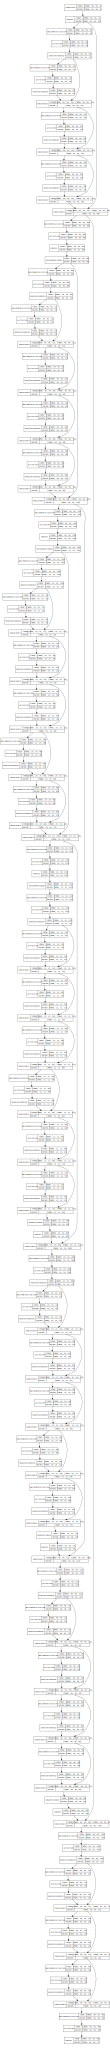

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

pydot_obj=model_to_dot(dnn.model,show_shapes=True,show_layer_names=False)
SVG(pydot_obj.create(prog='dot', format='svg'))

So now that we have our network ready, the next step is to train it.

During my internship, I used .fits files containing 10 000 galaxies each of size (96x96). Each file contains 4 HDU:
HDU 0: noisy convolved galaxies (never used those)
HDU 1: noiseless convolved galaxies
HDU 2: target galaxies convolved with gaussian PSF of FWHM=0.15 (irrelevent)
HDU 3: Euclid PSFs
HDU 4 target galaxies convolved with gaussian PSF of FWHM=0.07
Each HDU is one big image 9600x9600 containing the mosaic of the 10 000 samples

The DeepNet class has methods to train the network. 3 alternatives are possible:

-The data is already loaded in python, use:

    train(train_data, model_file = '', epochs=20, batch_size=32, validation_split=0.1)
train_data is a numpy array of shape (2, nb_samples, img_row, img_col, 1), the first dimension containing all the inputs of the network and the second dimension the ground truths. validation_split set the percentage of data for the valisation set. This method load your whole dataset directly so if you work with a huge set, you will pobably run out of memory, especially on GPU. You should try to opt for the other methods if possible.
    
-The data is already preprocessed inside .npy files and you want to load it one batch at a time:

    train_generator_npy(train_files, validation_file, epochs=20, batch_size=32, nb_img_per_file=10000)
as above, each file must contain an array of shape (2, nb_img_per_file, img_row, img_col, 1). A validation_file containing the validation set must be provided too.

-You want to read the fits and process the data on the fly:

    train_generator(train_files, validation_file, epochs=20, batch_size=32,
                        nb_img_per_file=10000, validation_set_size=10000,
                        noise_std=None, SNR=None,
                        noiseless_obs_hdu=0, targets_hdu=0, psf_hdu=0,
                        image_dim=96, image_per_row=100,
                        deconv_mode=None, rho_fista=1e-3)
so here you provides the list of fits files inside train_files and one validation file inside validation_files. You use hdu parameters to extract the desired values inside the fits. Functions inside batch_utils.py will automatically process the data from the fits and convert it to numpy array of the correct shape for the network.

In our case, we use this function as follows:

train_files (list of str): list of all our fits files containing the training set.

validation_file (str): validation set inside a fits file.

noise_std (int or list of 2 ints or None): int for constant noise, list of 2 ints [min_std, max_std] for a range of sigma and None if you want to use SNR instead.

SNR (int or list of 2 ints or None): same as noise_std but you input SNR values instead.

noiseless_obs_hdu (int): HDU in which the noiseless convolved galaxies are. Noise will be added according to the previous parameters.

targets_hdu (int): HDU containing the ground truths.

psf_hdu (int): HDU containing the PSFs.

image_dim (int): nb of rows/columns of each galaxy (we use square images).

image_per_row (int): images per row inside the fits mosaic (we use square mosaic in our fits files).

deconv_mode (None or 'TIKHONOV' or 'FISTA'): set the preprocessing to be applied on the input of the network.

rho_fista (float): only needed as a parameter for FISTA pre-processing.


The 2nd method is the best if you have limited computational ressources (but you have to do the preprocessing beforehand to generate all the .npy files).
The 3rd method provides an efficient method to do the pre-processing of each batch right before feeding it to the network for training. We use this method as an example in the following cells.
Both use the fit_generator method inside the model class in Keras. This function is the best to train the network without overloading your memory. It requires to define a generator, see dynamic_batches in batch_utils.npy for an example of implementation.

Note that for all the methods, a callback save automatically the network which got the best result on validation data (using MSE). If model_file is left empty, the model will be saved in the current working directory as "network_name.hdf5". Input the string containing the wanted path/name in model_file (with .hdf5 extension) to chose save location.

In [7]:
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/"

#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-*-multihdu.fits')
gal_files.sort()
print(gal_files)

win_files = glob.glob(write_path+'window/'+'Gaussian*')
win_files.sort()
print(win_files)


SNR = [20,100]#Range of SNR simulated
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
deconv_mode = 'TIKHONOV'


['/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-1-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-10-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-11-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-12-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-13-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-14-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-15-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-16-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-17-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-18-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-19-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-2-mult

In [8]:

#Train with the image-000-0.fits as validation and all the other files as training set
#dnn.train_generator(gal_files[1:], gal_files[0], epochs=20, batch_size=32,
#                        nb_img_per_file=10000, validation_set_size=10000,
#                        noise_std=None, SNR=SNR, model_file='',
#                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                        image_dim=96, image_per_row=100,
#                        deconv_mode=deconv_mode)
#Here the number of epochs is set to 2, should be on the order of 20 at the end
dnn.train_generator(gal_files[2:4], gal_files[1], epochs=10, batch_size=32,
                        model_file='', nb_img_per_file=100, 
                        validation_set_size=100, noise_std=None, SNR=SNR, 
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                        psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                        deconv_mode=deconv_mode, win_validation_filename=win_files[1],win_filename=win_files[2:4],win_hdu=0,mom_hdu=1)

Model will be saved at /home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_gamma0.hdf5
Memory usage for the model + one batch (GB): 2.809000
Not using any previous monitored value for checkpoint


/home/cben-ali/Programs/deep-deconv/python/DeepDeconv/deepnetFCS/DeepNet.py:363: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=10, validation_data=([array([[..., verbose=1, callbacks=[<DeepDeco..., initial_epoch=0, steps_per_epoch=8)`
  initial_epoch=initial_epoch)


Epoch 1/10
8/8 [==============================] - 22s 3s/step - loss: 76.0222 - weighted_mean_squared_error: 76.0222 - weighted_shape_metric: 0.0000e+00 - val_loss: 352.7431 - val_weighted_mean_squared_error: 352.7431 - val_weighted_shape_metric: 0.0000e+00

Epoch 00001: val_loss improved from inf to 352.74315, saving model to ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_gamma0.hdf5
2019-06-14_16:28:34 - Epoch: 1, val_loss: 352.743148, val_weighted_mean_squared_error: 352.743148, val_weighted_shape_metric: 0.000000, loss: 74.662123, weighted_mean_squared_error: 74.662123, weighted_shape_metric: 0.000000
Epoch 2/10
8/8 [==============================] - 4s 491ms/step - loss: 11.6817 - weighted_mean_squared_error: 11.6817 - weighted_shape_metric: 0.0000e+00 - val_loss: 123.8367 - val_weighted_mean_squared_error: 123.8367 - val_weighted_shape_metric: 0.0000e+00

Epoch 00002: val_loss improved from 352.74315 to 123.83672, saving model to ShapeNet2D_FCS_claire_sc4_layer

In [9]:
dnn.model.inputs


[<tf.Tensor 'input_1:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'window:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'norm:0' shape=(?, 6, 1, 1) dtype=float32>]

In [10]:
import keras.backend as K
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
from DeepDeconv.utils.batch_utils import get_batch_from_fits
import numpy as np
test_data, target_data,weights_data = get_batch_from_fits(gal_files[1], idx_list=np.arange(10000), SNR=[20,100],
                         noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                         image_dim=96, image_per_row=100,
                          deconv_mode=deconv_mode,shape_constraint=True,win_filename=win_files[1],win_hdu=0,mom_hdu=1)


print(test_data)
print(dnn.model.inputs)


#pred=dnn.predict(test_data,verbose=1)

#weighted_loss2 = weighted_masked_objective(losses.get('mse'))
#weighted_loss = weighted_masked_objective(dnn.shape_metric)
#print(K.eval(weighted_loss(K.variable(np.array((x,x))),
                               #K.variable(np.array((y,y))),
                              # weights_data,
                              # None)))
#print(K.eval(weighted_loss2(K.variable(np.array((x,x))),
                              # K.variable(np.array((y,y))),weights_data,None)))


[array([[[[ 4.10726734e-02],
         [ 1.12672418e-01],
         [ 6.06796266e-02],
         ...,
         [-7.79656096e-02],
         [-1.48156348e-01],
         [-5.70430174e-02]],

        [[-2.90116171e-02],
         [-2.29007169e-02],
         [ 5.70668510e-05],
         ...,
         [-5.78841785e-02],
         [-1.03873798e-01],
         [-3.84958452e-02]],

        [[ 1.03363529e-02],
         [-3.69202663e-02],
         [ 5.14316399e-02],
         ...,
         [-3.17032625e-02],
         [-2.04326422e-02],
         [ 5.44328131e-02]],

        ...,

        [[ 1.79795760e-02],
         [-3.57058067e-02],
         [-2.95982569e-02],
         ...,
         [-4.95346381e-02],
         [-5.87643706e-02],
         [ 2.83236969e-02]],

        [[-3.28715582e-02],
         [-4.59461092e-02],
         [-7.99310006e-02],
         ...,
         [-2.00198991e-02],
         [-1.04515143e-01],
         [-5.16356142e-02]],

        [[ 3.16302132e-02],
         [ 1.08401711e-01],
         

In [11]:
pred=dnn.predict(test_data,verbose=1)

10000/10000 [==============================] - 134s 13ms/step


In [12]:
dnn.model.inputs[1]=K.variable(test_data[1])
dnn.model.inputs[2]=K.variable(test_data[2])
dnn.gamma=1

In [13]:
print(target_data)

[[[[ 1.70809301e-07]
   [ 3.72176402e-07]
   [ 2.64893401e-07]
   ...
   [-3.09596686e-08]
   [-4.37324177e-09]
   [ 6.97441678e-08]]

  [[-5.42496537e-09]
   [ 7.37469918e-07]
   [ 8.75907631e-07]
   ...
   [ 2.26848087e-08]
   [ 6.77564600e-08]
   [ 5.76792161e-08]]

  [[ 7.28827729e-07]
   [ 5.07988432e-07]
   [ 4.82350856e-07]
   ...
   [ 9.43112397e-08]
   [-3.98664959e-08]
   [ 3.64880250e-08]]

  ...

  [[-5.60182514e-08]
   [-8.88818974e-08]
   [ 1.83231592e-07]
   ...
   [ 2.77340575e-07]
   [-9.82587594e-08]
   [ 2.28405398e-07]]

  [[-1.63460314e-07]
   [-1.77332851e-07]
   [ 4.94547479e-08]
   ...
   [-6.85199609e-07]
   [-4.47452848e-08]
   [-1.44046552e-07]]

  [[ 6.04736741e-08]
   [ 5.94359619e-08]
   [ 1.38406577e-07]
   ...
   [-4.47551457e-07]
   [-4.60644173e-07]
   [ 4.20794137e-08]]]


 [[[-1.46507346e-05]
   [-7.47260401e-06]
   [ 1.00883371e-05]
   ...
   [ 8.20847390e-07]
   [-2.26373731e-06]
   [-1.62114816e-06]]

  [[ 3.39894996e-06]
   [-1.44488570e-06]
   [

In [14]:
from keras.engine.training_utils import weighted_masked_objective
import keras.losses as losses
weighted_loss2 = weighted_masked_objective(losses.get('mse'))
weighted_loss = weighted_masked_objective(dnn.shape_metric)
pred=K.variable(pred)
target_data=K.variable(target_data)
weights_data=K.variable(weights_data)
#dnn.shape_metric(target_data,pred)
#losses.get('mse')(target_data,pred)
#print(np.shape(target_data))
#print(np.shape(pred))
#weights_data=weights_data.reshape(10000,1,1,1)
#print(np.shape(weights_data))

In [15]:
shap=K.get_value(weighted_loss(target_data,pred,weights_data,None))
meanse=K.get_value(weighted_loss2(target_data,pred,weights_data,None))
gamma=meanse/shap

In [16]:
print(gamma)

0.004210163


In [7]:
import numpy as np
best_epoch,best_val,nepochs=np.loadtxt(dnn.network_name+".hdf5.best_params")
print(int(best_epoch),best_val,int(nepochs))

10 2.4082292795181273 10


## Reload model, keep best_params validation loss

In [7]:
from DeepDeconv.deepnetFCS.DeepNet import DeepNet
dnn2=DeepNet(model_file="ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_gamma0.hdf5",shape_constraint=True,gamma=0.1) 
print(dnn2.model.inputs)
print(dnn2.model.input_names)

Loading model...
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_gamma0.hdf5
Renaming as...
ShapeNet2D_FCS_claire_sc4_layer4x5x6x7_relu_growthRate12_with_mom_gamma0
Tensor("loss_1/conv2d_8_loss/strided_slice:0", shape=(96, 96), dtype=float32) Tensor("window_1:0", shape=(?, 96, 96, 1), dtype=float32) Tensor("norm_1:0", shape=(?, 6, 1, 1), dtype=float32) Tensor("loss_1/conv2d_8_loss/sub:0", shape=(?, 96, 96, ?), dtype=float32)
[<tf.Tensor 'input_1_1:0' shape=(?, 96, 96, 1) dtype=float32>, <tf.Tensor 'window_1:0' shape=(?, 96, 96, 1) dtype=float32>, <tf.Tensor 'norm_1:0' shape=(?, 6, 1, 1) dtype=float32>]
['input_1', 'window', 'norm']


In [9]:
dnn2.model.weighted_metrics

['mean_squared_error',
 <bound method DeepNet.shape_metric of <DeepDeconv.deepnetFCS.DeepNet.DeepNet object at 0x7f767c140b00>>]

In [11]:
dnn2.train_generator(gal_files[2:4], gal_files[1], epochs=20, batch_size=32,
                        model_file=, nb_img_per_file=10, 
                        validation_set_size=10, noise_std=None, SNR=SNR, 
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                        psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                        deconv_mode=deconv_mode, win_validation_filename=win_files[1],win_filename=win_files[2:4],win_hdu=0,mom_hdu=1,
                        initial_epoch=10,keep_best_loss=True)

Memory usage for the model + one batch (GB): 0.130000
Current best_parameters: 10 175.59481811523438
Epoch 11/20


/home/cben-ali/Programs/deep-deconv/python/DeepDeconv/deepnetFCS/DeepNet.py:361: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=20, validation_data=([array([[..., verbose=1, callbacks=[<DeepDeco..., initial_epoch=10, steps_per_epoch=2)`
  initial_epoch=initial_epoch)


2/2 [==============================] - 2s 1s/step - loss: 26164530.5000 - mean_squared_error: 1.7994 - shape_metric: 49203.7871 - val_loss: 3239581.5000 - val_mean_squared_error: 0.9411 - val_shape_metric: 10446.8154

Epoch 00011: val_loss did not improve from 175.59482
2019-06-12_09:04:22 - Epoch: 11, val_loss: 3239581.500000, val_mean_squared_error: 0.941115, val_shape_metric: 10446.815430, loss: 26164530.500000, mean_squared_error: 1.799418, shape_metric: 49203.787109
Epoch 12/20
2/2 [==============================] - 0s 40ms/step - loss: 21465584.0000 - mean_squared_error: 1.7595 - shape_metric: 25838.9902 - val_loss: 3047753.5000 - val_mean_squared_error: 1.0598 - val_shape_metric: 9063.4414

Epoch 00012: val_loss did not improve from 175.59482
2019-06-12_09:04:22 - Epoch: 12, val_loss: 3047753.500000, val_mean_squared_error: 1.059804, val_shape_metric: 9063.441406, loss: 21465584.000000, mean_squared_error: 1.759477, shape_metric: 25838.990234
Epoch 13/20
2/2 [===================

## Reload model, do not keep best_params validation loss

In [8]:
dnn2.train_generator(gal_files[2:4], gal_files[1], epochs=10, batch_size=32,
                        model_file='ShapeNet2D_FCS_claire_sc1_layer2_relu_growthRate2_with_mom_test_restart.hdf5', nb_img_per_file=10, 
                        validation_set_size=10, noise_std=None, SNR=SNR, 
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                        psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                        deconv_mode=deconv_mode, win_validation_filename=win_files[1],win_filename=win_files[2:4],
                        win_hdu=0,mom_hdu=1)#,keep_best_loss=False by default

Model will be saved at /home/cben-ali/Programs/deep-deconv/tutorials/ShapeNet2D_FCS_claire_sc1_layer2_relu_growthRate2_with_mom_test_restart.hdf5
Memory usage for the model + one batch (GB): 2.809000
Not using any previous monitored value for checkpoint
Epoch 1/10


/home/cben-ali/Programs/deep-deconv/python/DeepDeconv/deepnetFCS/DeepNet.py:363: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=10, validation_data=([array([[..., verbose=1, callbacks=[<DeepDeco..., initial_epoch=0, steps_per_epoch=2)`
  initial_epoch=initial_epoch)


2/2 [==============================] - 13s 6s/step - loss: 499216.8281 - weighted_mean_squared_error: 1.5992 - weighted_shape_metric: 499215.2188 - val_loss: 207185.2656 - val_weighted_mean_squared_error: 0.8978 - val_weighted_shape_metric: 207184.3594

Epoch 00001: val_loss improved from inf to 207185.26562, saving model to ShapeNet2D_FCS_claire_sc1_layer2_relu_growthRate2_with_mom_test_restart.hdf5
2019-06-12_11:11:44 - Epoch: 1, val_loss: 207185.265625, val_weighted_mean_squared_error: 0.897755, val_weighted_shape_metric: 207184.359375, loss: 499216.828125, weighted_mean_squared_error: 1.599206, weighted_shape_metric: 499215.218750
Epoch 2/10
2/2 [==============================] - 0s 241ms/step - loss: 293493.3281 - weighted_mean_squared_error: 2.1796 - weighted_shape_metric: 293491.1797 - val_loss: 663571.2500 - val_weighted_mean_squared_error: 1.1968 - val_weighted_shape_metric: 663570.0000

Epoch 00002: val_loss did not improve from 207185.26562
2019-06-12_11:11:44 - Epoch: 2, va